In [1]:
!pip install librosa soundfile --quiet

import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# parameter umum
DURATION_LIMIT = 30     # detik
TARGET_SR = None        # None = pakai sample rate asli
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512


In [2]:
from google.colab import files

uploaded = files.upload()
mp3_name = list(uploaded.keys())[0]
mp3_name


Saving Avicii - The Nights (Lyrics) my father told me.mp3 to Avicii - The Nights (Lyrics) my father told me.mp3


'Avicii - The Nights (Lyrics) my father told me.mp3'

In [3]:
# simpan mp3 ke disk
with open(mp3_name, 'wb') as f:
    f.write(uploaded[mp3_name])


def mp3_to_wav_30s(mp3_path, duration_limit=DURATION_LIMIT, target_sr=TARGET_SR):
    """
    Load hanya 'duration_limit' detik pertama dari MP3,
    simpan sebagai WAV 30 detik, dan return y, sr, wav_path.
    """
    y, sr = librosa.load(mp3_path, sr=target_sr, duration=duration_limit, mono=True)
    wav_path = os.path.splitext(mp3_path)[0] + "_30s.wav"
    sf.write(wav_path, y, sr)
    return y, sr, wav_path


def compute_fft(y, sr, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    FFT via STFT -> magnitude spectrogram.
    Return: frekuensi, magnitude rata-rata, dan S_mag (untuk spectral features).
    """
    S_complex = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_mag = np.abs(S_complex)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mag_mean = S_mag.mean(axis=1)
    return freqs, mag_mean, S_mag


def compute_spectral_features(S_mag, sr, n_fft=N_FFT):
    """
    Hitung 6 spectral features:
    centroid, skewness, rolloff, kurtosis, spread, flatness.
    Nilai dikembalikan sebagai rata-rata (mean) antar frame.
    """
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    P = S_mag**2
    P_sum = P.sum(axis=0, keepdims=True) + 1e-10
    P_norm = P / P_sum

    # centroid
    centroid_frame = (freqs[:, None] * P_norm).sum(axis=0)
    centroid = centroid_frame.mean()

    # diff & spread
    diff = freqs[:, None] - centroid_frame[None, :]
    spread_frame = np.sqrt((diff**2 * P_norm).sum(axis=0) + 1e-10)
    spread = spread_frame.mean()

    # skewness & kurtosis
    skew_frame = (diff**3 * P_norm).sum(axis=0) / (spread_frame**3 + 1e-10)
    skewness = skew_frame.mean()

    kurt_frame = (diff**4 * P_norm).sum(axis=0) / (spread_frame**4 + 1e-10)
    kurtosis = kurt_frame.mean()

    # rolloff & flatness dari librosa
    rolloff = librosa.feature.spectral_rolloff(S=S_mag, sr=sr, roll_percent=0.85).mean()
    flatness = librosa.feature.spectral_flatness(S=S_mag).mean()

    return {
        "centroid": centroid,
        "skewness": skewness,
        "rolloff": rolloff,
        "kurtosis": kurtosis,
        "spread": spread,
        "flatness": flatness,
    }


def compute_mfcc_features(y, sr, n_mfcc=N_MFCC):
    """
    Hitung MFCC, lalu ambil mean & std tiap koefisien.
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)
    return mfcc_mean, mfcc_std


In [4]:
# 1) MP3 -> WAV 30 detik
y_30, sr, wav_path = mp3_to_wav_30s(mp3_name)

print("MP3       :", mp3_name)
print("WAV 30s   :", wav_path)
print("Durasi    :", len(y_30)/sr, "detik")
print("Sample sr :", sr)

# 2) FFT
freqs, mag_mean, S_mag = compute_fft(y_30, sr)

# 3) Spectral features
spec = compute_spectral_features(S_mag, sr)

# 4) MFCC
mfcc_mean, mfcc_std = compute_mfcc_features(y_30, sr)

print("\nSpectral features:")
for k, v in spec.items():
    print(f"  {k:10s}: {v:.4f}")

print("\nMFCC mean shape:", mfcc_mean.shape)
print("MFCC std  shape:", mfcc_std.shape)


/tmp/ipython-input-2795218590.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(mp3_path, sr=target_sr, duration=duration_limit, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


MP3       : Avicii - The Nights (Lyrics) my father told me.mp3
WAV 30s   : Avicii - The Nights (Lyrics) my father told me_30s.wav
Durasi    : 30.0 detik
Sample sr : 44100

Spectral features:
  centroid  : 1460.9286
  skewness  : 4.3280
  rolloff   : 7068.6906
  kurtosis  : 45.9460
  spread    : 1655.1298
  flatness  : 0.0064

MFCC mean shape: (13,)
MFCC std  shape: (13,)


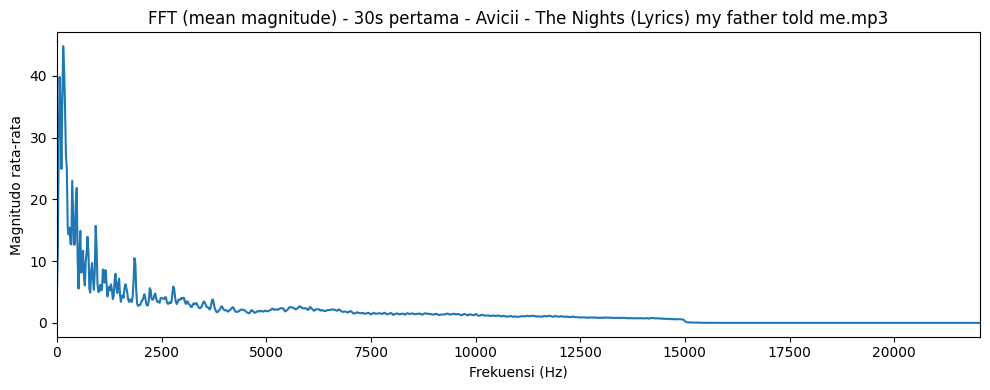

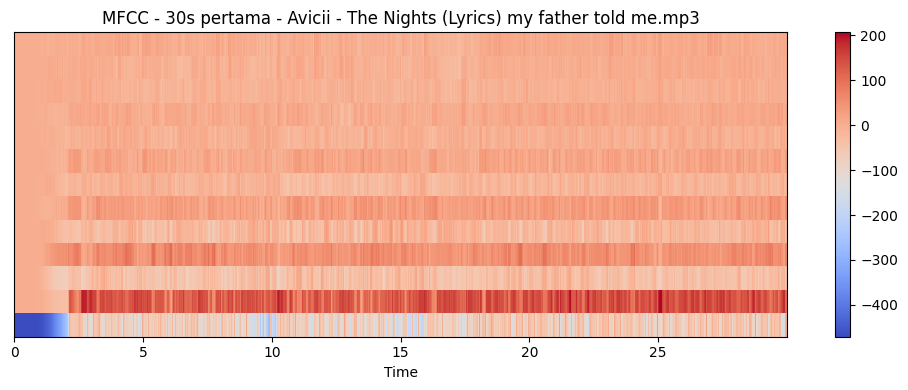

In [5]:
# FFT (magnitude rata-rata)
plt.figure(figsize=(10, 4))
plt.plot(freqs, mag_mean)
plt.title(f"FFT (mean magnitude) - 30s pertama - {mp3_name}")
plt.xlabel("Frekuensi (Hz)")
plt.ylabel("Magnitudo rata-rata")
plt.xlim(0, sr/2)
plt.tight_layout()
plt.show()

# MFCC spectrogram
mfcc = librosa.feature.mfcc(y=y_30, sr=sr, n_mfcc=N_MFCC)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCC - 30s pertama - {mp3_name}")
plt.tight_layout()
plt.show()


In [6]:
# gabung fitur jadi 1 vector
feature_vector = [
    spec["centroid"], spec["skewness"], spec["rolloff"],
    spec["kurtosis"], spec["spread"], spec["flatness"],
]
feature_vector += mfcc_mean.tolist()
feature_vector += mfcc_std.tolist()

print("Jumlah atribut fitur:", len(feature_vector))  # harus 6 + 2*N_MFCC (default: 32)

# nama kolom
cols = [
    "spec_centroid", "spec_skewness", "spec_rolloff",
    "spec_kurtosis", "spec_spread", "spec_flatness"
]
for i in range(N_MFCC):
    cols.append(f"mfcc_{i+1}_mean")
for i in range(N_MFCC):
    cols.append(f"mfcc_{i+1}_std")

df_single = pd.DataFrame([feature_vector], columns=cols)
df_single.insert(0, "filename", mp3_name)

df_single


Jumlah atribut fitur: 32


,filename,spec_centroid,spec_skewness,spec_rolloff,spec_kurtosis,spec_spread,spec_flatness,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,...,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,mfcc_13_std
0,Avicii - The Nights (Lyrics) my father told me...,1460.928631,4.327974,7068.69059,45.945972,1655.129773,0.00638,-98.699173,122.186821,-32.980377,...,19.620773,19.444874,16.291946,13.147364,13.224999,10.372646,10.444235,8.63133,9.945414,9.86377


In [7]:
csv_name = "testing_audio_features.csv"
df_single.to_csv(csv_name, index=False)

from google.colab import files
files.download(csv_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>